# Linear Regression

This notebook explores implementing a vectorized gradient descent algorithm on a linear regression model, as well as implementing feature normalization, and solving for linear regression using the normal equation.

## Linear Regression with Vectorized Gradient Descent

### Linear Regression
In Linear Regression we are aiming to minimnize the cost, given the cost function $J(\theta)$ defined below. This will allow us to predict an output given a set of features (datapoints). In effect the model seeks to find the best linear relationship for each feature.

Here $m$ is the number of datasets in our model, $y^{(i)}$ is the output for the $i^{th}$ datapoint, and $n$ is the number of features.

\begin{equation*}
J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \Bigl( h_{\theta}(x^{(i)}) - y^{(i)} \Bigr)^{2}
\end{equation*}

Where our hypothesis $h_{\theta}(x^{(i)})$ for the $n$ features in dataset $x^{(i)}$ is

\begin{equation*}
 h_{\theta}(x^{(i)}) = \theta_{0} + \theta_{1}x_{1}^{(i)} + \ldots + \theta_{n}x_{n}^{(i)}
\end{equation*}

### Gradient Descent
One way to minimize the cost, is to calculate the rate of change of the cost (the gradient) and take a step in the negative direction relative to that change. This is known as gradient descent. This can be represented in the below equation.

For a given weight $\theta_{j}$ for a feature $j$, a step in the negative gradient direction is given by:

\begin{equation*}
\theta_{j} = \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^{m} \Bigl(h_{\theta}(x^{(i)}) - y^{(i)}\Bigr)x^{(i)}
\end{equation*}

Here $\alpha$ is a constant we assign to control how big each gradient step is, known as the *learning rate*.

### Vectorization
The above equations can be vectorized in order to efficiently implement them in code. When vectorized the cost function becomes

\begin{equation*}
J(\theta) = \frac{1}{2m} (H_{(m,1)} - Y_{(m,1)})^{T} \cdot (H_{(m,1)} - Y_{(m,1)})
\end{equation*}

Where 

\begin{equation*}
H_{(m,1)} = X_{(m,n)} \cdot \theta_{(n,1)}
\end{equation*}

- $X_{(m,n)}$ is the matrix representing the $n$ features for all datapoints $m$.
- $\theta_{(n,1)}$ is the transpose of the matrix representing the weights for the $n$ features.
- $Y_{(m,1)}$ is the matrix representing the outputs for all datapoints $m$.

A vectorized gradient step becomes

\begin{equation*}
\theta_{(n,1)} = \theta_{(n,1)} - \frac{\alpha}{m} X_{(n,m)}^{T} \cdot \bigl(H_{(m,1)} - Y_{(m,1)}\bigr) 
\end{equation*}

### Implementation
Below is the vectorized cost function and gradient descent implemented in python.

In [17]:
import numpy as np

def cost(X, Y, theta):
    '''Vectorized cost function
    
    Args:
        X (np.matrix): (m,n) matrix containing dataset
        Y (np.matrix): (m,1) matrix containing labelled outputs for dataset X
        theta (np.matrix): (n,1) Weights for dataset X
        
    Returns:
        J (float): Cost
    '''
    # Dataset size
    m, n = X.shape
    # Get hypothesis
    H = np.dot(X, theta)

    # Calculate cost
    J = (1/(2*m)) * np.dot((H-Y).T, (H - Y))

    return J.item()

def iterate_theta(X, Y, theta, alpha):
    '''Vectorized theta iteration (used as part of Gradient Descent)
    
    Args:
        X (np.matrix): (m,n) matrix containing dataset
        Y (np.matrix): (m,1) matrix containing labelled outputs for dataset X
        theta (np.matrix): (n,1) Weights for dataset X
        alpha (float): Learning rate
        
    Returns:
        theta (np.matrix): New theta
    '''
    m, n = X.shape
    
    # Get hypothesis matrix
    H = np.dot(X, theta)
    
    # X.T is transpose of X
    theta = theta - ((1 / m) * alpha * np.dot(X.T, (H - Y)))
    
    return theta

def gradient_descent(X, Y, alpha, delta=0.000001, max_iter=5000, theta=None):
    '''Vectorized Gradient Descent
    
    Args:
        X (np.matrix): (m,n) matrix containing dataset
        Y (np.matrix): (m,1) matrix containing labelled outputs for dataset X
        alpha (float): Learning rate
        delta (float): Convergence value to stop at, when difference between last and second to
            last cost is smaller than this, it is considered converged.
        max_iter (int): Maximum number of iterations to run through gradient descent for
        theta (np.matrix): (n,1) Starting theta (can be omitted and will initialize zeros)
        
    Returns:
        J_vals (List[float]): List of costs for each iteration
        theta_vals (List[np.matrix]): List of theta values for each iteration
    '''
    # Initialize lists to store iteration results
    theta_vals = []
    J_vals = []

    m, n = X.shape
    
    # Initialize theta
    if theta is None:
        theta = np.zeros((n,1))
        theta = np.asmatrix(theta)

    theta_vals.append(theta)
    J_vals.append(cost(X, Y, theta))

    # Start iterations
    for idx in range(1,max_iter):
        theta = iterate_theta(X, Y, theta, alpha)
        
        J_vals.append(cost(X, Y, theta))
        theta_vals.append(theta)
        
        if (J_vals[-2] - J_vals[-1]) < delta:
            print('Difference is smaller than {} after {} iterations, stopping.'.format(delta, idx))
            print('Final cost: {:.3f}'.format(J_vals[-1]))
            return J_vals, theta_vals
        
    print('Maximum iteration reached: {}'.format(max_iter))
    print('Final cost: {:.3f}'.format(J_vals[-1]))
    
    return J_vals, theta_vals
        
            
    

### Example

Now that we have defined our functions, let's import some data and use these functions to find our optimal linear fit. 

#### Restaurant Chain
First let's plot the data.

Below we are looking at profit of a restaurant chain (y-axis) in a given city, with a feature being the population of the city (x-axis). Fitting a best fit curve will allow us to predict the profit given a population of a city.

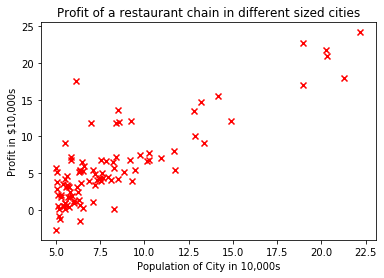

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

data = np.genfromtxt('data/ex1data1.txt', delimiter=',')
x = data[:,0]
y = data[:,1]

plt.scatter(x, y, marker='x', color='red')
plt.ylabel('Profit in $10,000s')
plt.xlabel('Population of City in 10,000s')
plt.title('Profit of a restaurant chain in different sized cities')
plt.show()

#### Run
Now let's run gradient descent on this dataset. 

First we should move our data into appropriate data structures, as well as adding a bias feature $\theta_{0}$ (this is in effect the intercept our of linear plot).

In [33]:
# Add theta_0 to X data
X = np.vstack((np.ones(len(x)), x))

# Convert to matrices
X = np.asmatrix(X)
X = X.T
Y = np.asmatrix(y)
Y = Y.T

print('Our X matrix is size ({0},{1})'.format(*X.shape))
print('Our Y matrix is size ({0},{1})'.format(*Y.shape))

Our X matrix is size (97,2)
Our Y matrix is size (47,1)




Let's begin gradient descent, here we're using a learning rate of 0.001.

After the function has finished we can then plot the cost against the number of iterations to visualise the gradient descent. Additionally we can plot the best fit line produced from the function.

In [20]:
# Set starting parameters
alpha = 0.001
J_vals, theta_vals = gradient_descent(X, Y, alpha)

Maximum iteration reached: 5000
Final cost: 4.714


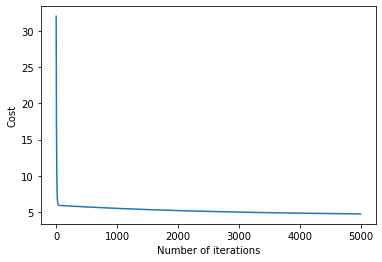

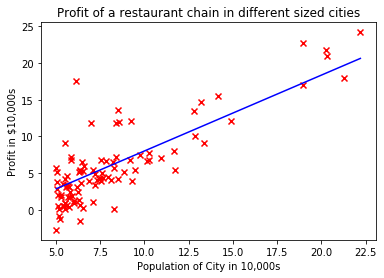

In [21]:
from plotting.linear_regression import plot_cost_function, plot_with_bestfit
    
plot_cost_function(J_vals)
min_idx = J_vals.index(np.amin(J_vals))
best_theta = theta_vals[min_idx]

plot_with_bestfit(x, y, best_theta)

## Feature Normalization

Now let's expand our model, using more features and *feature normalization*.

### Model
When using features that differ by orders of magnitude, we should include festure normalization within the model. This will shift the features so they are similar orders of magnitude, which will allow our algorithm to converge much quicker.

If our data is normally distributed, an effective way to normalize the data would be to subtract the mean $\mu$, then divide by the standard deviation $\sigma$. This in effect would shift our data such that the mean would become 0, and the standard deviation to 1.

\begin{equation*}
x_{norm}^{(i)} = \frac{x^{(i)} - \mu}{\sigma}
\end{equation*}

\begin{equation*}
\mu = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}
\end{equation*}

\begin{equation*}
\sigma = \sqrt{\frac{\sum_{i=1}^{m} (x^{(i)} - \mu)^{2}}{m}}
\end{equation*}

### Implementation
We can implement this normalization in a vectorized manner quite simply.

In [22]:
def normalize_data(X):
    '''Normalizes matrix dataset
    
    Args:
        X (np.matrix): (m,n) matrix containing dataset.
        
    Returns:
        X_norm (np.matrix): (m,n) matrix with normalized data, each feature n is normalized
            independently.
        mu (np.matrix): (1,n) matrix representing the mean value for each feature.
        sigma (np.matrix): (1,n) matrix representing the standard deviation for each feature.
    '''
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

### Example

#### Restaurant Chain
Now let's compare a normalized linear regression model to one without normalization. First let's use the data from the previous example, normalize it and run gradient descent.

Difference is smaller than 1e-06 after 659 iterations, stopping.
Final cost: 4.477


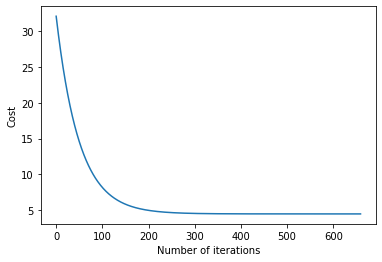

In [23]:
# Convert to x matrix form
X = np.asmatrix(x)
X = X.T

# Normalize X
X_norm, mu, sigma = normalize_data(X)
X_norm = np.hstack((np.transpose(np.matrix(np.ones(len(X_norm)))), X_norm))

# Run gradient descent
alpha = 0.01
J_vals, theta_vals = gradient_descent(X_norm, Y, alpha)

# Plot cost function
plot_cost_function(J_vals)

Let's plot and compare this to the previous example.

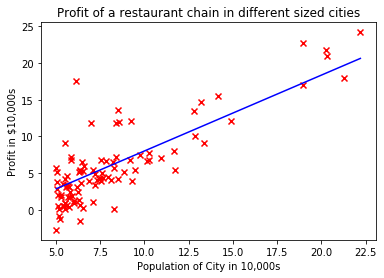

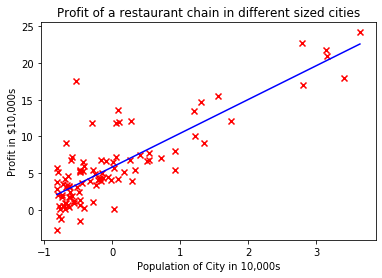

In [24]:
min_idx = J_vals.index(np.amin(J_vals))
best_norm_theta = theta_vals[min_idx]

plot_with_bestfit(x, y, best_theta)

plot_with_bestfit(X_norm[:,1], y, best_norm_theta)

Here the normalized data reaches a good line of best fit in almost 10x iterations.


#### Housing Price Prediction
Now we have implemented our normalization, let's use this with a new dataset and see how gradient descent performs.

In this dataset we have two unique features (number of bedrooms & size in square feet) that relate to the price of a house. We can plot this as a 3-D scatter graph.

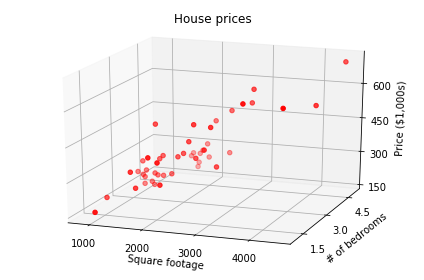

In [25]:
from plotting.linear_regression import plot_3d

# Load data
multi_data = np.genfromtxt('data/ex1data2.txt', delimiter=',')
x1 = multi_data[:,0]
x2 = multi_data[:,1]
y = multi_data[:,2]
y_val = y / 1000

# Plot data
plot_3d(x1, x2, y_val)

In [26]:
# Convert to vector/matrix format
Y = np.matrix(y)
Y = Y.T
X = np.concatenate((np.matrix(x1), np.matrix(x2)))
X = X.T

Now let's normalize our features. After (and not before) we've done that we should add the bias column.

In [27]:
X_norm, mu, sigma = normalize_data(X) 
X_norm = np.hstack((np.transpose(np.matrix(np.ones(len(X_norm)))), X_norm))

Now let's run gradient descent, and then visualize the *line of best fit* (though in this case it will be a plane as we have 2 input features).

Difference is smaller than 1e-06 after 352 iterations, stopping.
Final cost: 2043280050.603


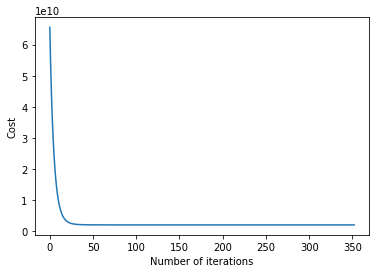

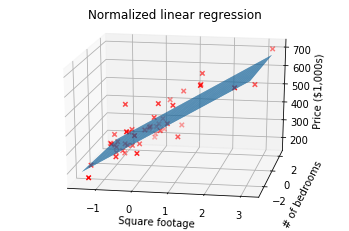

In [28]:
from plotting.linear_regression import plot_3d_with_bestfit

# Run gradient descent
J_vals, theta_vals = gradient_descent(X_norm, Y, 0.1)

# Plot the cost function
plot_cost_function(J_vals)

# Plot output with surface of best fit
plot_3d_with_bestfit(X_norm, y_val, theta_vals[-1])

Now let's write a function that will give us a prediction based on this normalised model.

In [29]:
def get_prediction(theta, mu, sigma, datapoint):
    '''Calculates predicted house price given a datapoint and model
    
    Args:
        theta_val (np.matrix): (n,1) matrix containing model weights.
        mu (np.matrix): (1,n) matrix representing the mean value for each feature
            for a given training dataset.
        sigma (np.matrix): (1,n) matrix representing the standard deviation for each feature
            for a given training dataset.
        datapoint (np.matrix): (1,n) datapoint you wish to predict house price for.
    '''
    d_norm = (datapoint - mu) / sigma
    d_norm = np.insert(d_norm, 0, 1)
    pred = np.dot(d_norm, theta)
    
    return pred.item(0)

In [30]:
n_beds = 3
sqr_feet = 1890

pred = get_prediction(theta_vals[-1], mu, sigma, np.matrix([sqr_feet, n_beds]))

print('A {0} bedroom house with {1} square feet\n'.format(n_beds, sqr_feet))
print('Gradient descent with normalization predicts: ${:,.2f}'.format(pred))

A 3 bedroom house with 1890 square feet

Gradient descent with normalization predicts: $326,492.03


## Normal Equation

Whilst you can use *Gradient Descent* to iteratively find the solution to minimizing the cost function $J_{(\theta)}$ of linear regression, there exists an analytical solution also.

This is known as the *Normal Equation*, and using this equation we can acquire the line of best fit. In a vectorized, it is defined below.

\begin{equation*}
\theta_{(n,1)} = (X_{(n,m)}^{T} \cdot X_{(m,n)} )^{-1} \cdot X_{(n,m)}^{T} \cdot Y_{(m,1)}
\end{equation*}

### Implementation

In [31]:
def normal_equation(X, Y):
    '''Normal equation for linear regression
    
    Args:
        X (np.matrix): (m,n) matrix containing dataset.
        Y (np.matrix): (m,1) matrix containing outputs.
    
    Returns:
        theta (np.matrix): (n,1) weights for linear regression fit.
    '''
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
    
    return theta

We can then use the normal equation to find the optimal solution for our housing price dataset.

In [32]:
# Prepare data
ones = np.transpose(np.matrix(np.ones(len(X))))
X_n = np.hstack((np.transpose(np.matrix(np.ones(len(X)))), X))

# Calculate solution
theta_norm = normal_equation(X_n, Y)

# Make prediction
print('A {0} bedroom house with {1} square feet\n'.format(n_beds, sqr_feet))
print('Normal equation predicts: ${:,.2f}\n'.format((n_beds*theta_norm[2] + sqr_feet*theta_norm[1] + theta_norm[0]).item(0)))
print('Gradient descent with normalization predicts: ${:,.2f}'.format(pred))

A 3 bedroom house with 1890 square feet

Normal equation predicts: $326,492.03

Gradient descent with normalization predicts: $326,492.03
